In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
original_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/INaturalist/Datasets', transform=transform)

In [20]:
# Sample subset of dataset
num_classes = 11
images_per_class = 50
class_indices = list(original_dataset.class_to_idx.values())
selected_classes = random.sample(class_indices, num_classes)
selected_indices = []

for class_idx in selected_classes:
    class_images = [i for i, (_, target) in enumerate(original_dataset) if target == class_idx]
    selected_indices.extend(random.sample(class_images, min(images_per_class, len(class_images))))

dataset = torch.utils.data.Subset(original_dataset, selected_indices)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the model with dropout
class ResNetWithDropout(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResNetWithDropout, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(original_model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Create model
model = models.resnet18(pretrained=True)
model = ResNetWithDropout(model, num_classes).to(device)

# Initialize fully connected layer
model.fc[1].weight.data.normal_(0, 0.01)
model.fc[1].bias.data.zero_()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [36]:
# Training loop with history
num_epochs = 20
best_val_acc = 0.0
patience = 5
no_improvement = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improvement = 0
    else:
        no_improvement += 1

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Best Val Acc: {best_val_acc:.4f}, "
          f"No Improvement: {no_improvement}")

    if no_improvement >= patience:
        print("Early stopping")
        break

# Test function
def test(model, loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")
    return all_labels, all_predictions

100%|██████████| 4/4 [00:00<00:00, 15.43it/s]


Epoch 1/20, Train Loss: 1.4917, Train Acc: 0.4932, Val Loss: 2.3622, Val Acc: 0.3636, Best Val Acc: 0.3636, No Improvement: 0


100%|██████████| 4/4 [00:00<00:00, 14.63it/s]


Epoch 2/20, Train Loss: 1.5015, Train Acc: 0.5045, Val Loss: 2.6676, Val Acc: 0.2909, Best Val Acc: 0.3636, No Improvement: 1


100%|██████████| 4/4 [00:00<00:00, 14.15it/s]


Epoch 3/20, Train Loss: 1.5206, Train Acc: 0.5023, Val Loss: 2.3123, Val Acc: 0.3818, Best Val Acc: 0.3818, No Improvement: 0


100%|██████████| 4/4 [00:00<00:00, 16.13it/s]


Epoch 4/20, Train Loss: 1.4340, Train Acc: 0.5114, Val Loss: 2.2237, Val Acc: 0.4364, Best Val Acc: 0.4364, No Improvement: 0


100%|██████████| 4/4 [00:00<00:00, 16.70it/s]


Epoch 5/20, Train Loss: 1.4712, Train Acc: 0.4977, Val Loss: 2.4172, Val Acc: 0.4000, Best Val Acc: 0.4364, No Improvement: 1


100%|██████████| 4/4 [00:00<00:00, 13.94it/s]


Epoch 6/20, Train Loss: 1.4437, Train Acc: 0.4932, Val Loss: 2.3736, Val Acc: 0.2727, Best Val Acc: 0.4364, No Improvement: 2


100%|██████████| 4/4 [00:00<00:00, 15.22it/s]


Epoch 7/20, Train Loss: 1.3631, Train Acc: 0.5455, Val Loss: 2.4198, Val Acc: 0.3818, Best Val Acc: 0.4364, No Improvement: 3


100%|██████████| 4/4 [00:00<00:00, 13.43it/s]


Epoch 8/20, Train Loss: 1.3242, Train Acc: 0.5591, Val Loss: 2.3709, Val Acc: 0.4364, Best Val Acc: 0.4364, No Improvement: 4


100%|██████████| 4/4 [00:00<00:00, 15.77it/s]

Epoch 9/20, Train Loss: 1.3546, Train Acc: 0.5227, Val Loss: 2.3939, Val Acc: 0.4182, Best Val Acc: 0.4364, No Improvement: 5
Early stopping


100%|██████████| 4/4 [00:00<00:00, 14.55it/s]


Test Accuracy: 0.3273
                                                                                   precision    recall  f1-score   support

  00000_Animalia_Annelida_Clitellata_Haplotaxida_Lumbricidae_Lumbricus_terrestris       0.40      0.67      0.50         6
     00001_Animalia_Annelida_Polychaeta_Sabellida_Sabellidae_Sabella_spallanzanii       0.67      0.33      0.44         6
       00002_Animalia_Annelida_Polychaeta_Sabellida_Serpulidae_Serpula_columbiana       0.25      0.50      0.33         2
00003_Animalia_Annelida_Polychaeta_Sabellida_Serpulidae_Spirobranchus_cariniferus       0.20      1.00      0.33         1
        00004_Animalia_Arthropoda_Arachnida_Araneae_Agelenidae_Eratigena_duellica       0.29      0.33      0.31         6
     00005_Animalia_Arthropoda_Arachnida_Araneae_Antrodiaetidae_Atypoides_riversi       0.33      0.17      0.22         6
       00006_Animalia_Arthropoda_Arachnida_Araneae_Araneidae_Aculepeira_ceropegia       0.00      0.00      0.00    

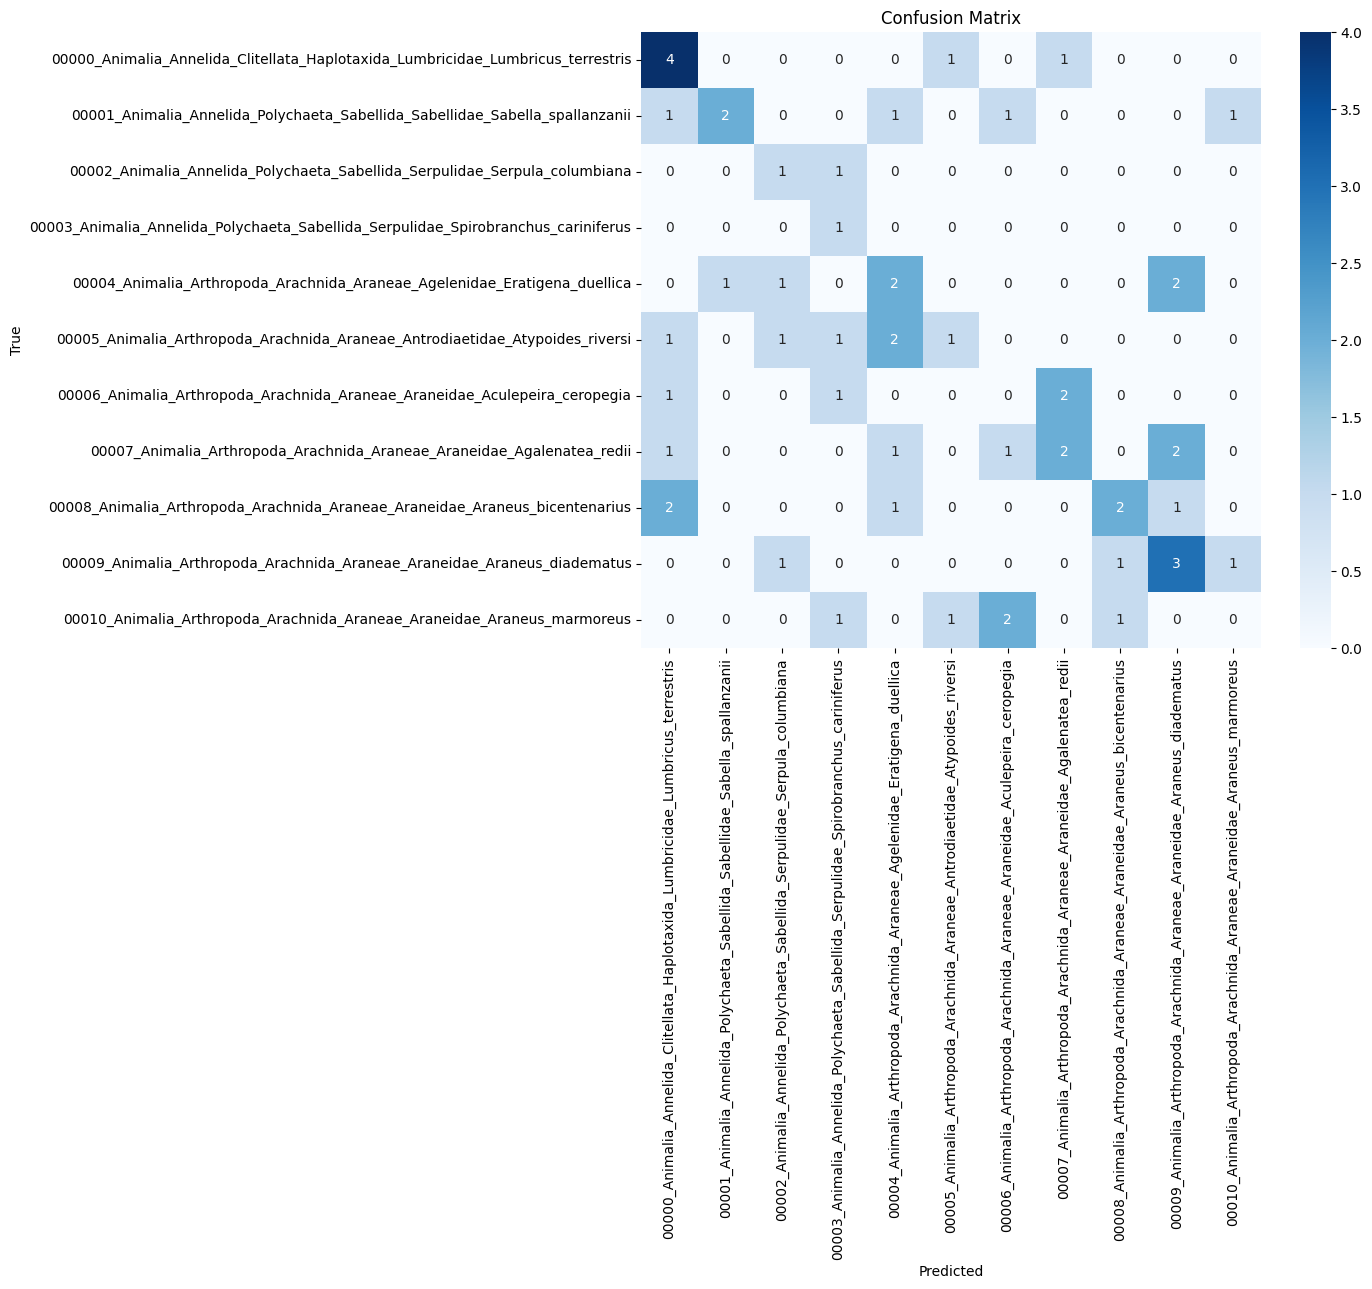

In [37]:
# Evaluate the model on the test set
all_labels, all_predictions = test(model, test_loader, device)

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=original_dataset.classes)
print(report)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=original_dataset.classes, yticklabels=original_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Save the model
model_save_path = '/content/resnet18_animal_species_detector.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/resnet18_animal_species_detector.pth


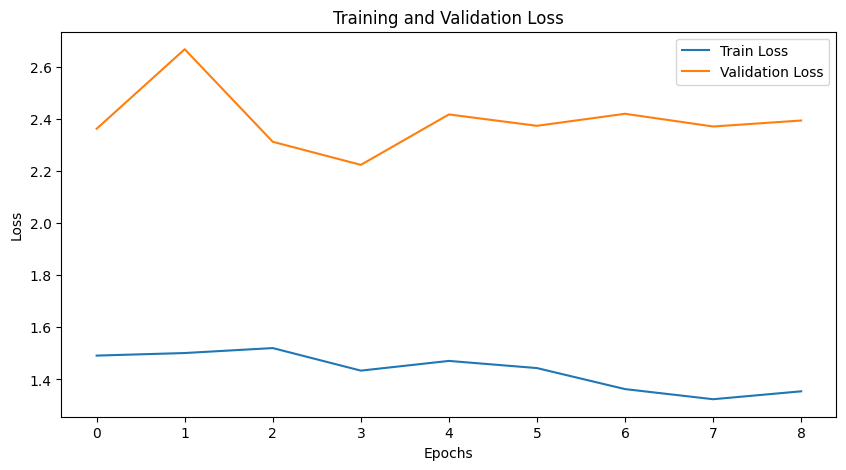

In [39]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

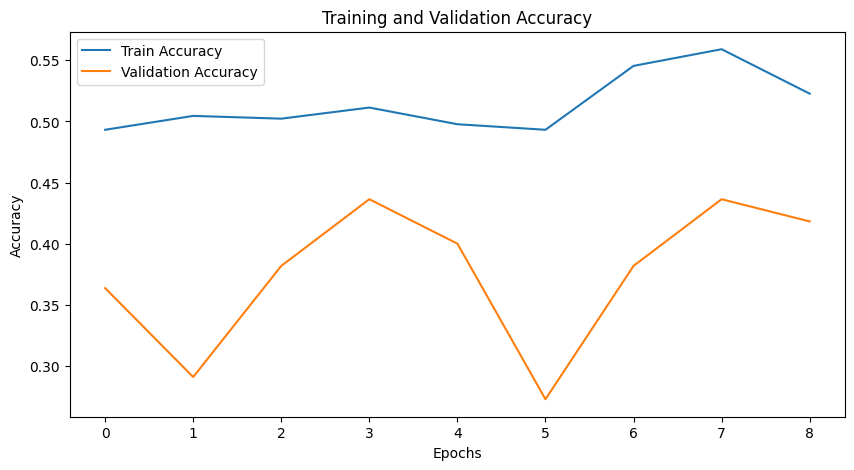

In [40]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

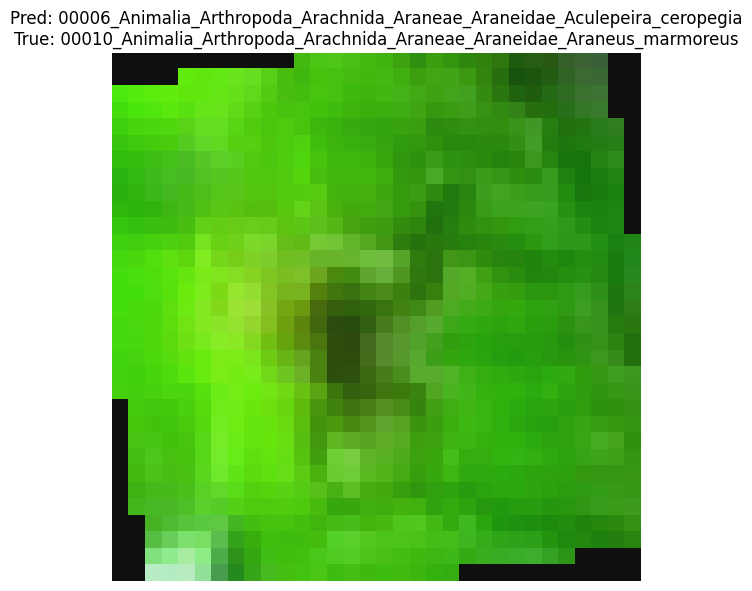

In [52]:
def visualize_predictions(model, loader, device, classes, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                images_so_far += 1
                # Ensure num_images//2 is at least 1 to have at least one row of plots
                ax = plt.subplot(max(num_images//2, 1), 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {classes[preds[j]]}\nTrue: {classes[labels[j]]}')
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    return

# Call the function with a suitable number of images (at least 2)
visualize_predictions(model, test_loader, device, original_dataset.classes, num_images=1)

In [53]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_

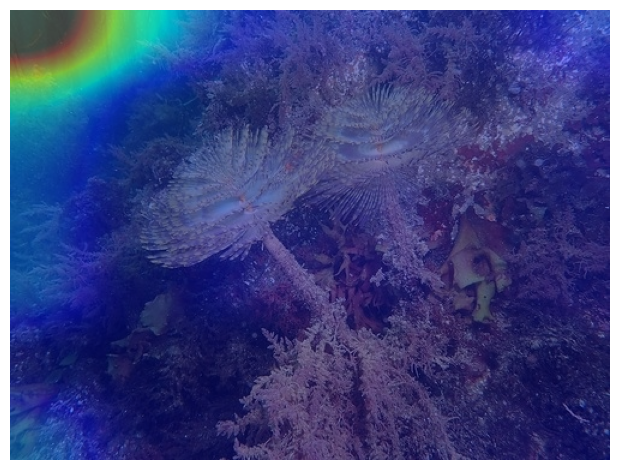

In [58]:
# Ensure you have torchcam installed
# !pip install torchcam

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import torch

# Use your trained model
model = models.resnet18(pretrained=True)
model = ResNetWithDropout(model, num_classes)  # Assuming you have defined your model architecture as ResNetWithDropout
model.load_state_dict(torch.load('/content/resnet18_animal_species_detector.pth'))  # Load the trained model weights
model = model.eval().to(device)

# Get a sample test image from your dataset
# Here, we use the image you uploaded
img_path = "/content/drive/MyDrive/Dataset/Validation/00001_Animalia_Annelida_Polychaeta_Sabellida_Sabellidae_Sabella_spallanzanii/1b905826-5abb-4de0-b34a-ea965a696f93.jpg"
img = read_image(img_path).to(device)

# Preprocess it for your model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

with SmoothGradCAMpp(model) as cam_extractor:
    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img.cpu()), to_pil_image(activation_map[0].squeeze(0).cpu(), mode='F'), alpha=0.5)

# Display the result
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()

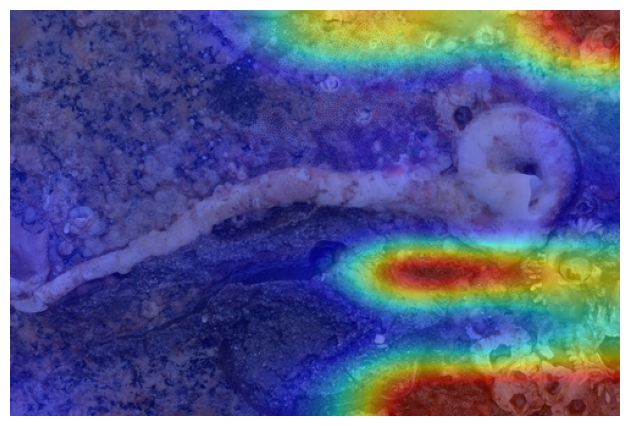

In [59]:
# Ensure you have torchcam installed
# !pip install torchcam

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import torch

# Use your trained model
model = models.resnet18(pretrained=True)
model = ResNetWithDropout(model, num_classes)  # Assuming you have defined your model architecture as ResNetWithDropout
model.load_state_dict(torch.load('/content/resnet18_animal_species_detector.pth'))  # Load the trained model weights
model = model.eval().to(device)

# Get a sample test image from your dataset
# Here, we use the image you uploaded
img_path = "/content/drive/MyDrive/Dataset/Validation/00002_Animalia_Annelida_Polychaeta_Sabellida_Serpulidae_Serpula_columbiana/8c8ac805-2c77-4666-9230-1b796ce796b5.jpg"
img = read_image(img_path).to(device)

# Preprocess it for your model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

with SmoothGradCAMpp(model) as cam_extractor:
    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img.cpu()), to_pil_image(activation_map[0].squeeze(0).cpu(), mode='F'), alpha=0.5)

# Display the result
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()